In [1]:
import os
import shutil

# Move kaggle.json to the correct directory
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permissions (just to be safe)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle datasets download -d landlord/handwriting-recognition



Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0
100% 1.26G/1.26G [00:38<00:00, 37.3MB/s]
100% 1.26G/1.26G [00:38<00:00, 35.0MB/s]


In this notebook, we'll go through the steps to train a CRNN (CNN+RNN) model for handwriting recognition. The model will be trained using the CTC(Connectionist Temporal Classification) loss.




Lets start by importing the necessary libraries. I'll be using Keras for building our CRNN model.

In [2]:
import zipfile

with zipfile.ZipFile('/content/handwriting-recognition.zip', 'r') as zip_ref:
    zip_ref.extractall('handwriting-recognition')

print('Dataset extracted successfully!')


Dataset extracted successfully!


In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [4]:
# It is necessaryr for a TPU to be running to the amount of data we are processing

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
except ValueError:
    print("Could not connect to TPU")
    tpu = None

# Select appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)


Could not connect to TPU
Number of accelerators:  1


## Load and view data

In [5]:
# Train and Validation Data
train = pd.read_csv('/content/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/content/handwriting-recognition/written_name_validation_v2.csv')

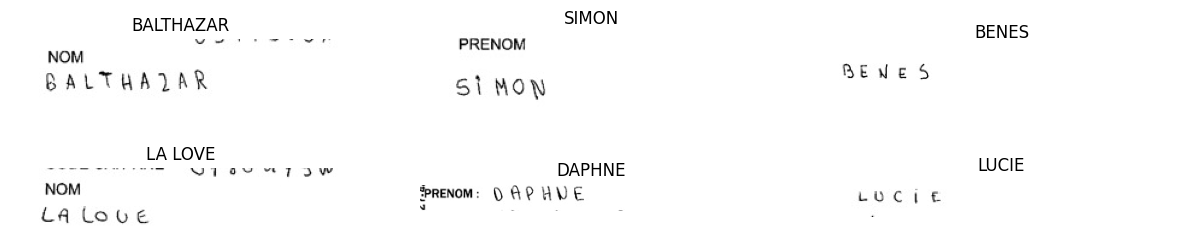

In [6]:
# Plotting data to see form of data
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

Let's check for NaNs in our label.

In [7]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [8]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

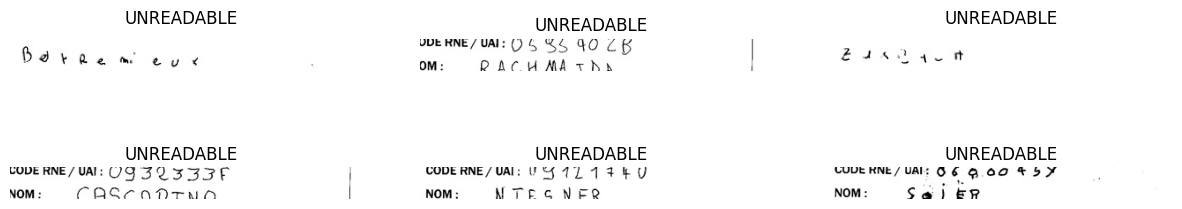

In [9]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)
# Removal of UnReadable Data
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [10]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [11]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

<ipython-input-11-0a9d753a51e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['IDENTITY'] = train['IDENTITY'].str.upper()
<ipython-input-11-0a9d753a51e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['IDENTITY'] = valid['IDENTITY'].str.upper()


Reset the index and we are done with cleaning.

In [12]:
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y).
* The image is then normalized to range [0, 1]

In [13]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [14]:
train_size = 100000
valid_size= 10000

In [15]:
# Train Data
train_x = []

for i in range(train_size):
    img_dir = '/content/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)


In [16]:
# Validation Data
valid_x = []

for i in range(valid_size):
    img_dir = '/content/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [17]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [18]:
# Checking if size of train and valid are same of that of declared
print(len(train_x))
print(len(valid_x))

100000
10000


## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space).

In [19]:

# Preparing for CTC Loss
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [20]:
# Checking if labeling works
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
* **train_label_len** contains the length of each true label (without padding)
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss.


In [21]:
max_str_len = max(train['IDENTITY'].apply(len))  # Determine the maximum length dynamically
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    identity_length = len(train.loc[i, 'IDENTITY'])
    train_label_len[i] = identity_length
    label_nums = label_to_num(train.loc[i, 'IDENTITY'])
    if len(label_nums) > max_str_len:
        raise ValueError(f"Label length exceeds max_str_len: {len(label_nums)} > {max_str_len}")
    train_y[i, 0:identity_length] = label_nums


In [22]:
# Assuming max_str_len, num_of_timestamps, and other parameters are already defined
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps - 2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    identity = valid.loc[i, 'IDENTITY']
    identity_length = len(identity)
    valid_label_len[i] = identity_length

    label_nums = label_to_num(identity)
    if len(label_nums) > max_str_len:
        raise ValueError(f"Validation label length exceeds max_str_len: {len(label_nums)} > {max_str_len}")

    valid_y[i, 0:identity_length] = label_nums


In [23]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [24]:
# from keras.models import load_model

# # Load the model
# model = load_model('model.h5')

In [25]:
# # Testing with uploaded data
# img_dir = '/content/Hey77732.png'
# image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
# plt.imshow(image, cmap='gray')

# image = preprocess(image)
# image = image/255.
# pred = model.predict(image.reshape(1, 256, 64, 1))
# decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
#                                     greedy=True)[0][0])
# plt.title(num_to_label(decoded[0]), fontsize=12)
# plt.axis('off')

# plt.subplots_adjust(wspace=0.2, hspace=-0.8)


## Building our model


In [26]:
# Building the Model if model isn't present
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [27]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [28]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [29]:
# from keras.models import load_model

# # Load the model ( same as above)
# model = load_model('my_model.h5')

## Train our model

In [30]:
from tensorflow.keras.optimizers import Adam

# Compile the model with a dummy lambda loss function
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))

# Fit the model and store the training history
history = model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
    epochs=25,
    batch_size=128
)


Epoch 1/25
782/782 [==============================] - 177s 207ms/step - loss: 21.2391 - val_loss: 19.1149
Epoch 2/25
782/782 [==============================] - 159s 203ms/step - loss: 16.9265 - val_loss: 14.4177
Epoch 3/25
782/782 [==============================] - 158s 203ms/step - loss: 9.4763 - val_loss: 6.1160
Epoch 4/25
782/782 [==============================] - 158s 202ms/step - loss: 5.3651 - val_loss: 4.0517
Epoch 5/25
782/782 [==============================] - 158s 202ms/step - loss: 4.0220 - val_loss: 3.1095
Epoch 6/25
782/782 [==============================] - 158s 202ms/step - loss: 3.3324 - val_loss: 2.7159
Epoch 7/25
782/782 [==============================] - 158s 203ms/step - loss: 2.9200 - val_loss: 2.4163
Epoch 8/25
782/782 [==============================] - 158s 203ms/step - loss: 2.6402 - val_loss: 2.2454
Epoch 9/25
782/782 [==============================] - 158s 202ms/step - loss: 2.4342 - val_loss: 2.1545
Epoch 10/25
782/782 [==============================] - 158s 

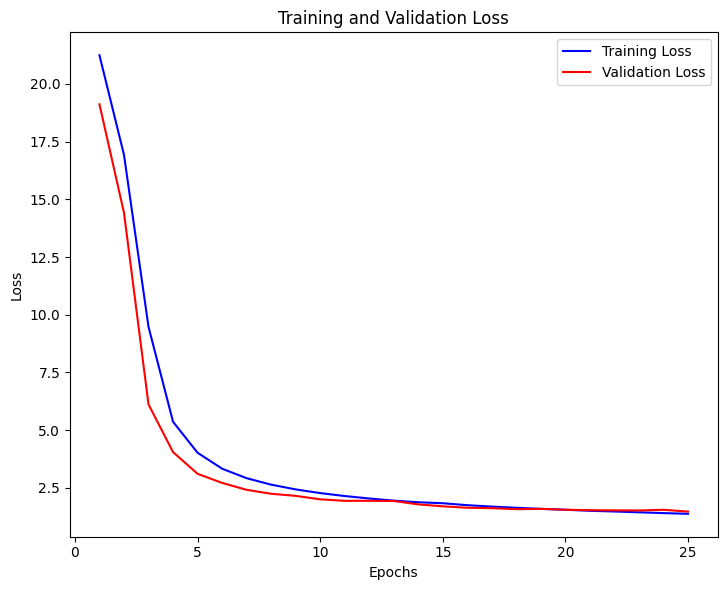

In [31]:
import matplotlib.pyplot as plt

# Extract metrics from history
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history.get('accuracy', [])  # Use .get() to avoid KeyError if accuracy is not tracked
val_accuracy = history.history.get('val_accuracy', [])  # Same for validation accuracy

# Plot Loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
if train_accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


## Check model performance on validation set

In [32]:
# Assuming your model is named 'model'
# Saving model to reduce model creation time for further use
model.save('/content/model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# storing both formats of the model file
model.save('/content/model.keras')


In [34]:
# Prediction
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))
print(prediction)

313/313 [==============================] - 6s 15ms/step
['BILEL', 'LAUMONIER', 'LEA', 'JEAN-ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN-MICHEL', 'JULIEN', 'NAEL', 'BILGER', 'TIFFANY', 'ELEEN', 'ANTOINE', 'AYOUB', 'MINETTE', 'RAINGEVAL', 'CELESTIN', 'DIBENEDETTO', 'MATHIS', 'LOUNA', 'SEVESTRE', 'DEVANLAY', 'HOCQVARD', 'LEBRUN', 'DABIN', 'SENDOUBI', 'DI PASQUAL', 'ARIVAT', 'HUGO', 'MAONI', 'COTTIGNY', 'SARRAZIN', 'FRERE', 'MONSOH', 'BELKERROUE', 'CLEMENT', 'ALLEMBRAND', 'CASSANDRA', 'VIEILLE', 'VAUTIER', 'LOUSSE', 'DUARRNER', 'ENNIO', 'ALYSSIA', 'RUIZ', 'LIZANA', 'BCAMILLE', 'JULIE', 'ELIA', 'AXEL', 'ANTOINE', 'NIOA', 'RICHAKD', 'COONAC', 'DAVOULT', 'SAAD', 'DUBOIS', 'NAU', 'JULIEN', 'BENET', 'DAUID', 'THOMAS', 'VAILLANT', 'JOAO', 'LYLOU', 'CARA', 'TABUT', 'PELLETIER', 'AUTRET', 'CHECROUN', 'VASSEUR', 'FAURE', 'EMMA', 'ARTHUR', 'FRIMIN', 'ANAELLE', 'JDUEAN', 'RAPHEL', 'VANTOMME', 'COMNES', 'ANTOINE', 'ANDRANIK', 'LUCAS', 'CELIA', 'LOURENCO', 'MAYLIS', 'LUCIE', 'DEBARD', 'DEPAQUY',

In [35]:
# Checking Accuracy of the Model
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1


print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 91.64%
Correct words predicted      : 80.76%


## Some predictions on test set

1/1 [==============================] - 0s 22ms/step


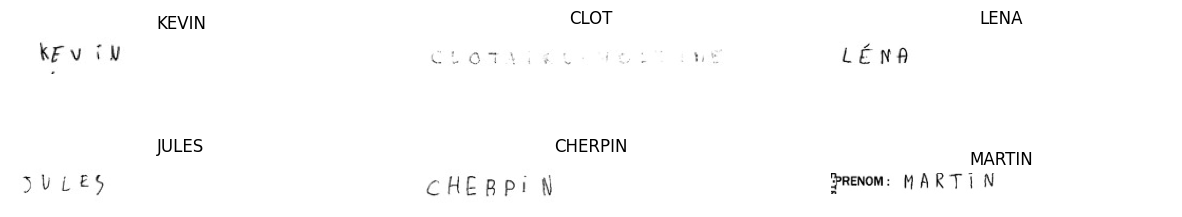

In [36]:
# Predidctions on basis of Test Data
test = pd.read_csv('/content/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

1/1 [==============================] - 0s 22ms/step


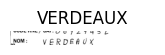

In [37]:
# Prediction based on Uploaded Data
ax = plt.subplot(2, 3, i+1)
img_dir = '/content/handwriting-recognition/test_v2/test/TEST_0106.jpg'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                    greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Ways to improve the model

* Use more training samples. This will help the model to learn and generalise better. I have used only 10% of the images as the entire training set cannot be loaded into kaggle's memory.
* There are multiple images in the training set which are not at all legible to the human eye. Removing such images will help in model's learning.